<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/LondonBikeSharing_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install gdown
#!pip install tensorflow-gpu

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional 

In [3]:
import seaborn as sns

In [7]:
data = pd.read_csv('/content/london_merged.csv')

In [8]:
data.head(10)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [9]:
data.shape

(17414, 10)

Vemos que tenemos una cantidad bastante buena de muestras.

Las variables son:

"timestamp" - timestamp field for grouping the data

"cnt" - the count of a new bike shares

"t1" - real temperature in C

"t2" - temperature in C "feels like"

"hum" - humidity in percentage

"windspeed" - wind speed in km/h

"weathercode" - category of the weather

"isholiday" - boolean field - 1 holiday / 0 non holiday

"isweekend" - boolean field - 1 if the day is weekend

"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

"weathe_code" category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


# EDA - Exploratory Data Analysis

In [8]:
target = 'cnt'
features = [i for i in data.columns if i not in [target]]

print("Target:", target)
print("Variables de contexto:", features)

Target: cnt
Variables de contexto: ['timestamp', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']


In [9]:
data.isnull().values.sum()

0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


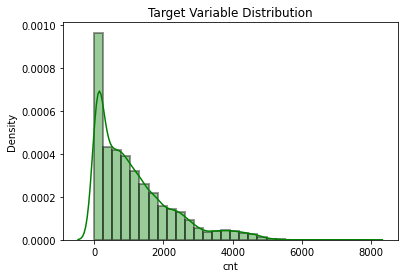

In [10]:
plt.figure()
sns.distplot(data[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution')
plt.show()

In [11]:
#convertir "timestamp" a formato datatime para poder separar la información en variables
#data['timestamp'] = pd.to_datetime(data.iloc['timestamp'])

data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp")
'''
data["year"] = data['timestamp'].dt.year #años
data["month"] = data['timestamp'].dt.month #meses
data["day_of_month"] = data['timestamp'].dt.day #día del mes
data["day_of_week"] = data['timestamp'].dt.weekday #dia de la semana
data["hour"] = data['timestamp'].dt.hour #horas
data.head()
'''
data['hour'] = data.index.hour #horas
data["day_of_week"] = data.index.weekday
data["day_of_month"] = data.index.day
data["month"] = data.index.month
data["year"] = data.index.year

In [12]:
#timestamp
target = data['cnt'].values
t1 = data['t1'].values
t2 = data['t2'].values
hum = data['hum'].values
viento = data['wind_speed'].values
tiempo = data['weather_code'].values
festivo = data['is_holiday'].values
#is_weekend
#season
#year
mes = data['month'].values
dia = data['day_of_week'].values
hora = data['hour'].values

In [13]:
data.head(4)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month,year
timestamp,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1,2015
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1,2015
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1,2015
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1,2015


In [14]:
data.shape[0]

17414

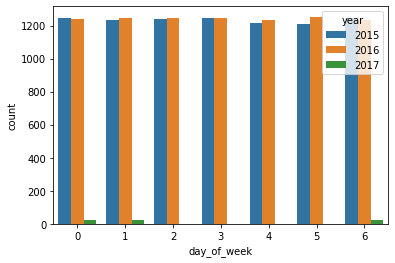

In [15]:
sns.countplot(x="day_of_week", hue="year", data=data) 

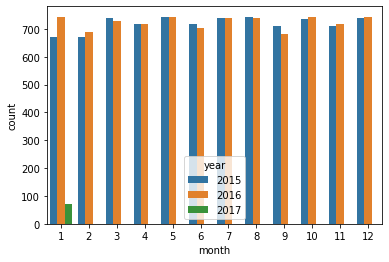

In [16]:
sns.countplot(x="month", hue="year", data=data)

In [17]:
# vemos que tenemos datos de los años 2015 y 2016 completos
# y del año 2017 solo diponemos de un mes.

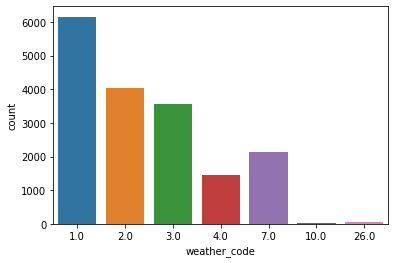

In [18]:
sns.countplot(x="weather_code", data=data)

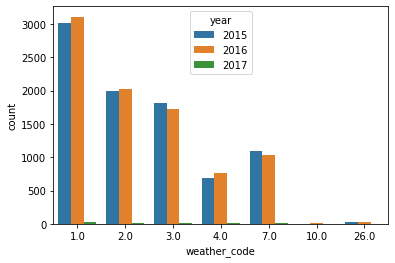

In [19]:
sns.countplot(x="weather_code", hue = 'year', data=data)

In [20]:
#como es de esperar los días con un tiempo más soleado se utilizan más las 
#bicicletas, como es de esperar.

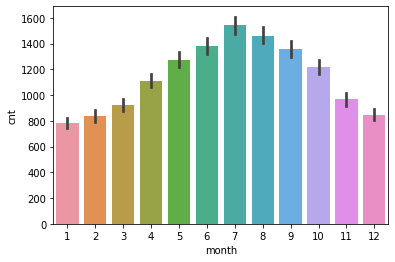

In [21]:
sns.barplot(x="month", y="cnt", data=data) #ojo, en enero tenemos más datos, quitarlo

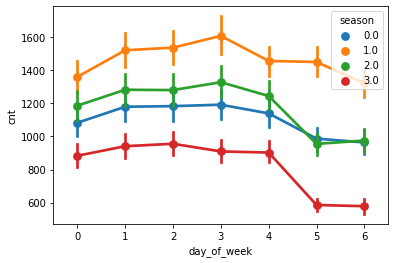

In [22]:
sns.pointplot(data=data, x="day_of_week", y="cnt", hue="season")

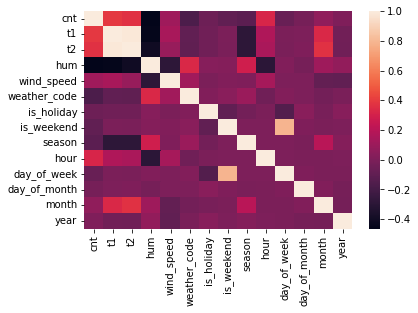

In [23]:
sns.heatmap(data.corr())

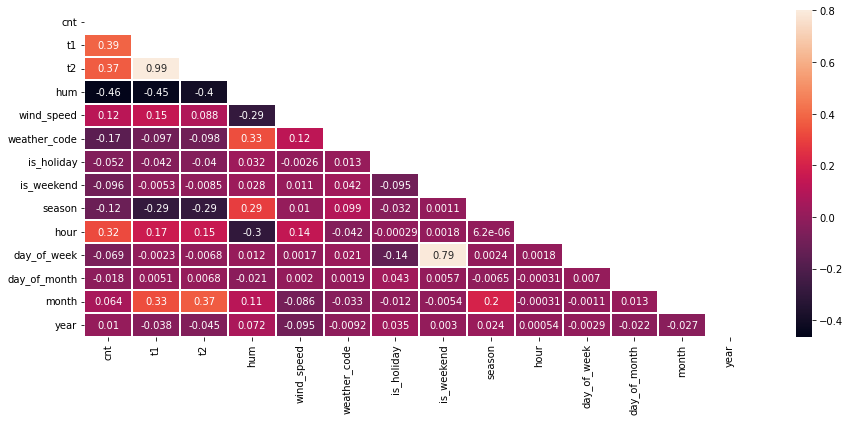

In [24]:
corrMatt = data.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=False, annot=True, ax=ax, linewidths=1);

In [ ]:
#como es normal t1 y t2 están estrechamente correlacionadas
#además "is_weekend" (fin de semana) y "day_of_week" también están 
#bastante corelacionadas, como es normal.

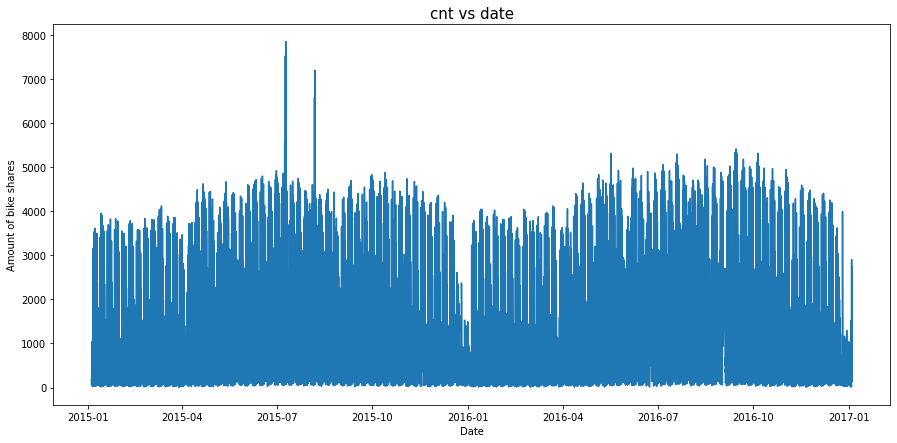

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.lineplot(data=data,x="timestamp",y="cnt")
ax.set_title("cnt vs date", fontsize=15)
ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel('Amount of bike shares', fontsize=10)
plt.show()

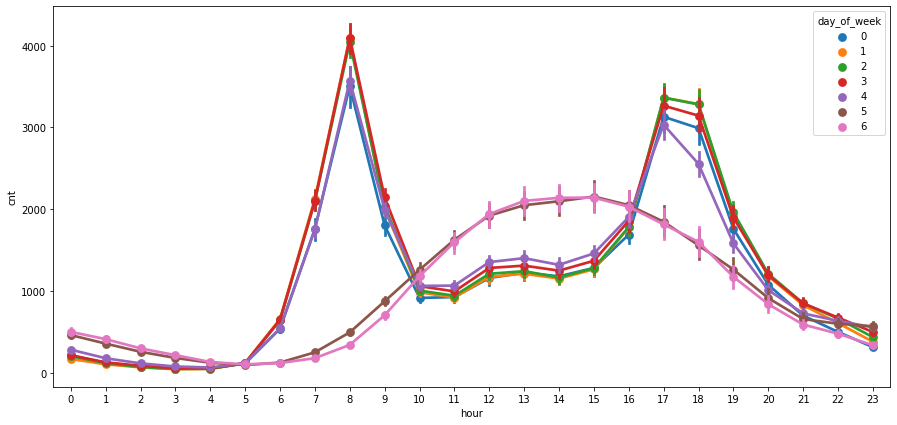

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='day_of_week', data=data)

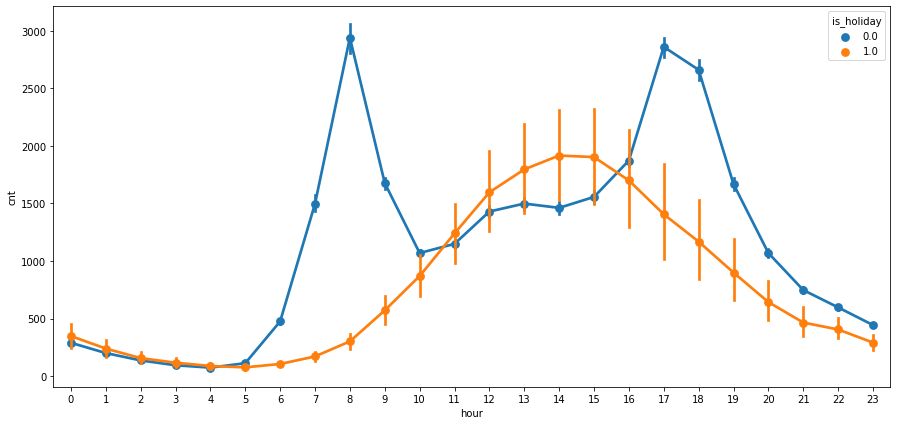

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='is_holiday', data=data)

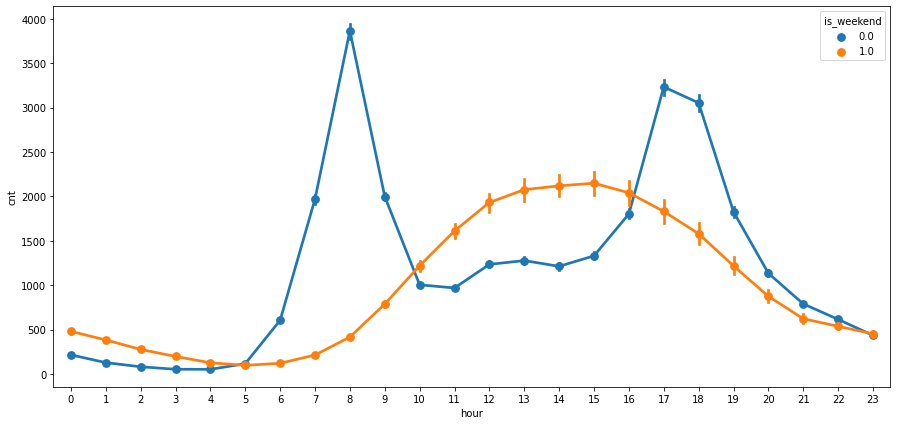

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='is_weekend', data=data)

In [ ]:
#vemos claramente que entre semana la gente se mueve en bicicleta con mayor frecuencia alrededor de las 8 y alrededor de las 18
#en cambio el fin de semana, se utilizan menos y además, los valores están más dispersos,
#encontrando mayor frecuencia de uso al medio dia.

In [25]:
'''
# interpolate weather, temp, atemp, humidity, windspeed
all_df["weather"] = all_df["weather"].interpolate(method='time').apply(np.round)
all_df["temp"] = all_df["temp"].interpolate(method='time')
all_df["atemp"] = all_df["atemp"].interpolate(method='time')
all_df["humidity"] = all_df["humidity"].interpolate(method='time').apply(np.round)
all_df["windspeed"] = all_df["windspeed"].interpolate(method='time')
'''

'\n# interpolate weather, temp, atemp, humidity, windspeed\nall_df["weather"] = all_df["weather"].interpolate(method=\'time\').apply(np.round)\nall_df["temp"] = all_df["temp"].interpolate(method=\'time\')\nall_df["atemp"] = all_df["atemp"].interpolate(method=\'time\')\nall_df["humidity"] = all_df["humidity"].interpolate(method=\'time\').apply(np.round)\nall_df["windspeed"] = all_df["windspeed"].interpolate(method=\'time\')\n'

In [26]:
# Mas preproceso 
#data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')

# Preprocessing

In [11]:
data_final = data[['t1',
 'hum',
 'wind_speed',
 'weather_code',
 'is_holiday',
 'is_weekend',
 'season',
 'cnt']]

 #si no tengo indexado timestamp deberé añadirlo como "label"

In [12]:
data_final.head()

,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,cnt
0,3.0,93.0,6.0,3.0,0.0,1.0,3.0,182
1,3.0,93.0,5.0,1.0,0.0,1.0,3.0,138
2,2.5,96.5,0.0,1.0,0.0,1.0,3.0,134
3,2.0,100.0,0.0,1.0,0.0,1.0,3.0,72
4,2.0,93.0,6.5,1.0,0.0,1.0,3.0,47


## quitar

In [29]:
features

['timestamp',
 't1',
 't2',
 'hum',
 'wind_speed',
 'weather_code',
 'is_holiday',
 'is_weekend',
 'season']

In [31]:
#si no tengo indexado timestamp
#data.set_index(['timestamp'], inplace=True)

In [ ]:
#data.head()

In [32]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

In [33]:
target_names = ['t1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday']

In [34]:
df_targets = data[target_names].shift(-shift_steps)

In [35]:
data[target_names].head(shift_steps + 5)

,t1,t2,hum,wind_speed,weather_code,is_holiday
timestamp,,,,,,
2015-01-04 00:00:00,3.0,2.0,93.0,6.0,3.0,0.0
2015-01-04 01:00:00,3.0,2.5,93.0,5.0,1.0,0.0
2015-01-04 02:00:00,2.5,2.5,96.5,0.0,1.0,0.0
2015-01-04 03:00:00,2.0,2.0,100.0,0.0,1.0,0.0
2015-01-04 04:00:00,2.0,0.0,93.0,6.5,1.0,0.0
2015-01-04 05:00:00,2.0,2.0,93.0,4.0,1.0,0.0
2015-01-04 06:00:00,1.0,-1.0,100.0,7.0,4.0,0.0
2015-01-04 07:00:00,1.0,-1.0,100.0,7.0,4.0,0.0
2015-01-04 08:00:00,1.5,-1.0,96.5,8.0,4.0,0.0


In [36]:
df_targets.head(5)

,t1,t2,hum,wind_speed,weather_code,is_holiday
timestamp,,,,,,
2015-01-04 00:00:00,4.0,3.0,93.0,6.0,4.0,0.0
2015-01-04 01:00:00,4.0,3.5,93.0,5.0,4.0,0.0
2015-01-04 02:00:00,5.0,4.0,87.0,6.0,4.0,0.0
2015-01-04 03:00:00,6.0,4.5,84.0,7.5,4.0,0.0
2015-01-04 04:00:00,6.5,5.0,84.0,8.0,4.0,0.0


In [37]:
df_targets.tail()

,t1,t2,hum,wind_speed,weather_code,is_holiday
timestamp,,,,,,
2017-01-03 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
x_data = data.values[0:-shift_steps]

print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (17390, 14)


In [39]:
y_data = df_targets.values[:-shift_steps]

print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (17390, 6)


In [40]:
train_split = 0.9
num_data = len(x_data)
num_train = int(train_split * num_data)
num_train

15651

In [41]:
num_test = num_data - num_train
num_test

1739

In [42]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

17390

In [43]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

17390

In [44]:
num_x_signals = x_data.shape[1]
num_x_signals

14

In [45]:
num_y_signals = y_data.shape[1]
num_y_signals

6

In [46]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -6.0
Max: 7860.0


In [47]:
from sklearn.preprocessing import MinMaxScaler

In [48]:
x_scaler = MinMaxScaler()

In [49]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [50]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [51]:
x_test_scaled = x_scaler.transform(x_test)

In [52]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## train / test

In [13]:
train_split = 0.9
num_data = len(data_final)
num_train = int(train_split * num_data)
num_train

num_test = num_data - num_train
num_test

train, test = data_final.iloc[0:num_train], data_final.iloc[(num_train):len(data_final)]
print(data_final.shape, train.shape, test.shape)

(17414, 8) (15672, 8) (1742, 8)


In [14]:
'''
punto_corte = int(len(data_final)*train_split)
time_steps = 10
fechas = []
fechas_train = timestamp[time_steps:punto_corte] # elimino los lookback primeros al tener NANs

fechas_test  = fechas[punto_corte:]
'''

'\npunto_corte = int(len(data_final)*train_split)\ntime_steps = 10\nfechas = []\nfechas_train = timestamp[time_steps:punto_corte] #\xa0elimino los lookback primeros al tener NANs\n\nfechas_test  = fechas[punto_corte:]\n'

In [15]:
int(train.shape[0]) + int(test.shape[0])

17414

In [58]:
#Escalamos datos para un mejor rendimiento de la red y un menor coste comuptacional

In [16]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 'hum', 'wind_speed']

f_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())

train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)

test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [17]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
#cnt_transformer = scaler.fit_transform(train[['cnt']]) 

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
train.tail(10)

,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,cnt
15662,-0.3750,0.425,-0.818182,1.0,0.0,1.0,2.0,0.074936
15663,-0.3750,0.425,-0.909091,2.0,0.0,1.0,2.0,0.069211
15664,-0.5000,0.675,-1.000000,3.0,0.0,1.0,2.0,0.058142
15665,-0.5000,0.675,-1.090909,3.0,0.0,1.0,2.0,0.054580
15666,-0.5625,0.825,-0.909091,2.0,0.0,1.0,2.0,0.045165
15667,-0.6250,0.825,-0.818182,2.0,0.0,1.0,2.0,0.027608
15668,-0.6250,0.975,-0.818182,2.0,0.0,1.0,2.0,0.019084
15669,-0.6250,0.675,-1.000000,3.0,0.0,1.0,2.0,0.013613
15670,-0.6250,0.825,-0.772727,3.0,0.0,1.0,2.0,0.013613
15671,-0.6875,0.825,-0.818182,1.0,0.0,1.0,2.0,0.022010


In [19]:
print(train.cnt.max())
print(train.cnt.min())

1.0
0.0


In [20]:
test.head(20)

,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,cnt
15672,-0.6250,0.675,-0.818182,2.0,0.0,1.0,2.0,0.062728
15673,-0.4375,0.275,-0.454545,2.0,0.0,1.0,2.0,0.148725
15674,-0.3125,0.025,0.000000,3.0,0.0,1.0,2.0,0.273169
15675,-0.1250,-0.200,0.636364,2.0,0.0,1.0,2.0,0.382639
15676,-0.1250,-0.325,0.818182,2.0,0.0,1.0,2.0,0.436463
15677,-0.0625,-0.300,0.818182,2.0,0.0,1.0,2.0,0.490894
15678,0.0000,-0.525,0.909091,2.0,0.0,1.0,2.0,0.443950
15679,0.0000,-0.425,0.727273,2.0,0.0,1.0,2.0,0.485026
15680,-0.1250,-0.325,0.727273,2.0,0.0,1.0,2.0,0.416835
15681,-0.1250,-0.200,0.818182,3.0,0.0,1.0,2.0,0.367665


In [21]:
print(test.cnt.max())
print(test.cnt.min())

1.0
0.0


In [22]:
#time_steps = lag = # lag is the number of previous values to consider for predicting next one
def create_dataset(X, y, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values # slice of "lag" length starting at i
        dataX.append(v)        
        dataY.append(y.iloc[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [23]:
train.cnt

0        0.023155
1        0.017557
2        0.017048
3        0.009160
4        0.005980
           ...   
15667    0.027608
15668    0.019084
15669    0.013613
15670    0.013613
15671    0.022010
Name: cnt, Length: 15672, dtype: float64

In [24]:
#time_steps = 10
time_steps = 48

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

#print(X_train.shape, y_train.shape)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# reshape to [samples, time_steps, n_features]

(15624, 48, 8)
(1694, 48, 8)
(15624,)
(1694,)


In [70]:
print(X_train[-1, 0:]) #10 o 48 time steps y 8 features, var. contexto
print(X_test[-1, 0:]) 

[[-0.375       0.725      -0.27272727  2.          0.          0.
   2.          0.26552163]
 [-0.375       0.725      -0.09090909  2.          0.          0.
   2.          0.54109415]
 [-0.375       0.725       0.          7.          0.          0.
   2.          0.28918575]
 [-0.3125      0.575       0.          7.          0.          0.
   2.          0.14796438]
 [-0.1875      0.3         0.18181818  2.          0.          0.
   2.          0.14351145]
 [-0.125       0.175       0.09090909  3.          0.          0.
   2.          0.18256997]
 [ 0.         -0.075      -0.09090909  3.          0.          0.
   2.          0.1975827 ]
 [ 0.         -0.2         0.          3.          0.          0.
   2.          0.17989822]
 [ 0.0625     -0.425      -0.18181818  3.          0.          0.
   2.          0.19071247]
 [ 0.         -0.075      -0.27272727  3.          0.          0.
   2.          0.2692112 ]
 [ 0.         -0.075      -0.54545455  3.          0.          0.
   2

In [72]:
'''
print(X_train[5])
print(X_train[-5])
'''
print(y_train[5])
print(y_train[-5]) #cnt escalado

0.009414758269720101
0.027608142493638677


# LSTM

In [ ]:
model_0 = Sequential()
model_0.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2])))  # input_shape=[time steps, features]
model_0.add(Dense(1))
model_0.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
model_0 = Sequential()
model_0.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2])))
model_0.add(Dense(units = 512, activation = 'relu'))
model_0.add(Dense(units = 1, activation = 'linear'))
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1067008   
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,330,177
Trainable params: 1,330,177
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_0.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
model_0.fit(X_train, y_train, epochs=20, batch_size=2, verbose=2)

Epoch 1/20
7812/7812 - 154s - loss: 0.0058 - 154s/epoch - 20ms/step
Epoch 2/20
7812/7812 - 148s - loss: 0.0015 - 148s/epoch - 19ms/step
Epoch 3/20
7812/7812 - 149s - loss: 0.0011 - 149s/epoch - 19ms/step
Epoch 4/20
7812/7812 - 148s - loss: 8.5633e-04 - 148s/epoch - 19ms/step
Epoch 5/20
7812/7812 - 148s - loss: 8.0393e-04 - 148s/epoch - 19ms/step
Epoch 6/20
7812/7812 - 148s - loss: 7.4549e-04 - 148s/epoch - 19ms/step
Epoch 7/20
7812/7812 - 149s - loss: 6.9382e-04 - 149s/epoch - 19ms/step
Epoch 8/20
7812/7812 - 148s - loss: 6.3393e-04 - 148s/epoch - 19ms/step
Epoch 9/20
7812/7812 - 147s - loss: 6.2448e-04 - 147s/epoch - 19ms/step
Epoch 10/20
7812/7812 - 148s - loss: 6.0991e-04 - 148s/epoch - 19ms/step
Epoch 11/20
7812/7812 - 147s - loss: 5.4508e-04 - 147s/epoch - 19ms/step
Epoch 12/20
7812/7812 - 146s - loss: 5.2565e-04 - 146s/epoch - 19ms/step
Epoch 13/20
7812/7812 - 146s - loss: 5.4544e-04 - 146s/epoch - 19ms/step
Epoch 14/20
7812/7812 - 146s - loss: 5.0086e-04 - 146s/epoch - 19ms/step

In [28]:
# make predictions

y_pred_test = model_0.predict(X_test)
y_pred_train = model_0.predict(X_train)

In [29]:
# invert scaling

y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
#y_test_pred_inv = scaler.inverse_transform(y_pred_test)
#y_train_pred_inv = scaler.inverse_transform(y_pred_train)


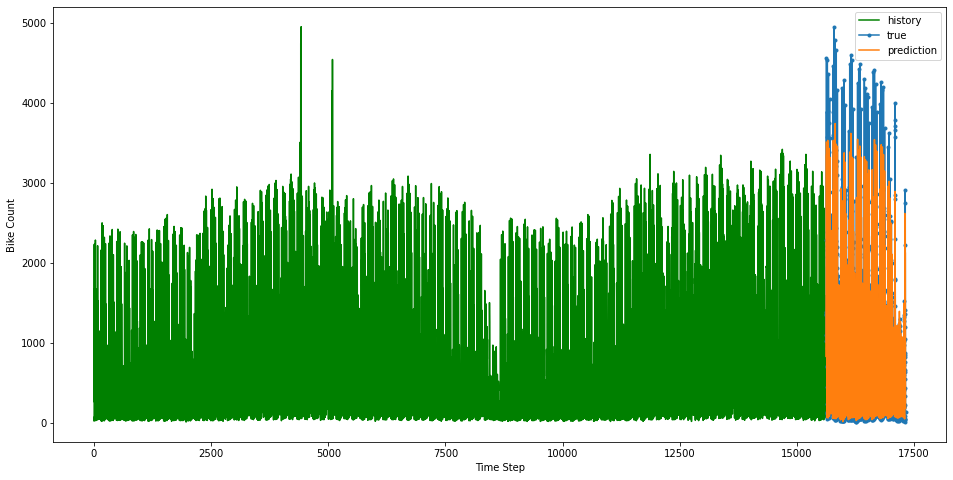

In [30]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [42]:
y_train_inv.shape

(1, 15624)

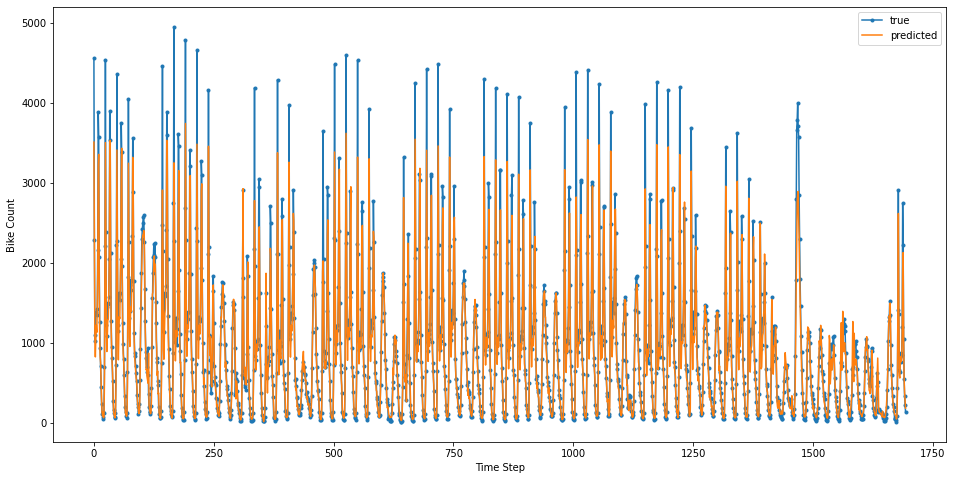

In [31]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [32]:
y_pred_test_inv

array([[3507.7112 ],
       [2351.9456 ],
       [1064.6718 ],
       ...,
       [ 381.69595],
       [ 289.48877],
       [ 181.67502]], dtype=float32)

In [34]:
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 96.50 RMSE
Test Score: 234.93 RMSE


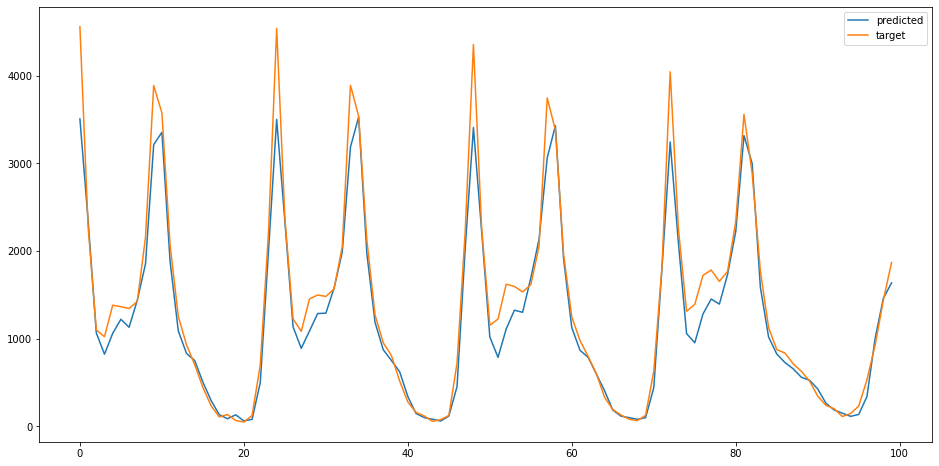

In [35]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

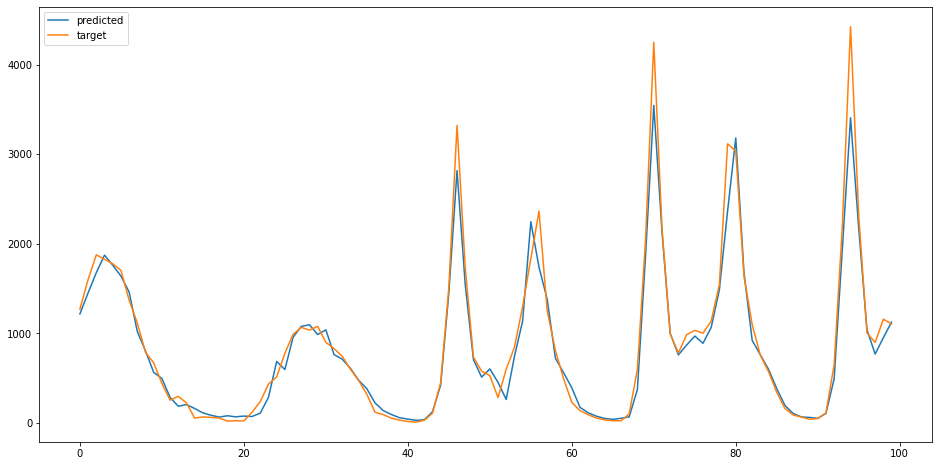

In [36]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()

# LSTM BIDIRECTIONAL

In [ ]:

model = Sequential()
model.add(Bidirectional(
    LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
15662/15662 [==============================] - 114s 7ms/step - loss: 0.0073
Epoch 2/20
15662/15662 [==============================] - 104s 7ms/step - loss: 0.0017
Epoch 3/20
15662/15662 [==============================] - 105s 7ms/step - loss: 0.0014
Epoch 4/20
15662/15662 [==============================] - 104s 7ms/step - loss: 0.0012
Epoch 5/20
15662/15662 [==============================] - 108s 7ms/step - loss: 0.0011
Epoch 6/20
15662/15662 [==============================] - 107s 7ms/step - loss: 0.0011
Epoch 7/20
15662/15662 [==============================] - 106s 7ms/step - loss: 0.0011
Epoch 8/20
15662/15662 [==============================] - 105s 7ms/step - loss: 9.9781e-04
Epoch 9/20
15662/15662 [==============================] - 104s 7ms/step - loss: 9.5573e-04
Epoch 10/20
15662/15662 [==============================] - 103s 7ms/step - loss: 9.4889e-04
Epoch 11/20
15662/15662 [==============================] - 105s 7ms/step - loss: 8.9818e-04
Epoch 12/20
15662/15662 [

In [ ]:
'''
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)
'''

In [ ]:
'''
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();
'''

In [ ]:
'''
y_pred_test = model_0.predict(X_test)
y_pred_train = model_0.predict(X_train)
'''

# make predictions

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
# invert scaling

y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
#y_test_pred_inv = scaler.inverse_transform(y_pred_test)
#y_train_pred_inv = scaler.inverse_transform(y_pred_train)
'''
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
'''

'\ntrainPredict = scaler.inverse_transform(trainPredict)\ntrainY = scaler.inverse_transform([y_train])\ntestPredict = scaler.inverse_transform(testPredict)\ntestY = scaler.inverse_transform([y_test])\n'

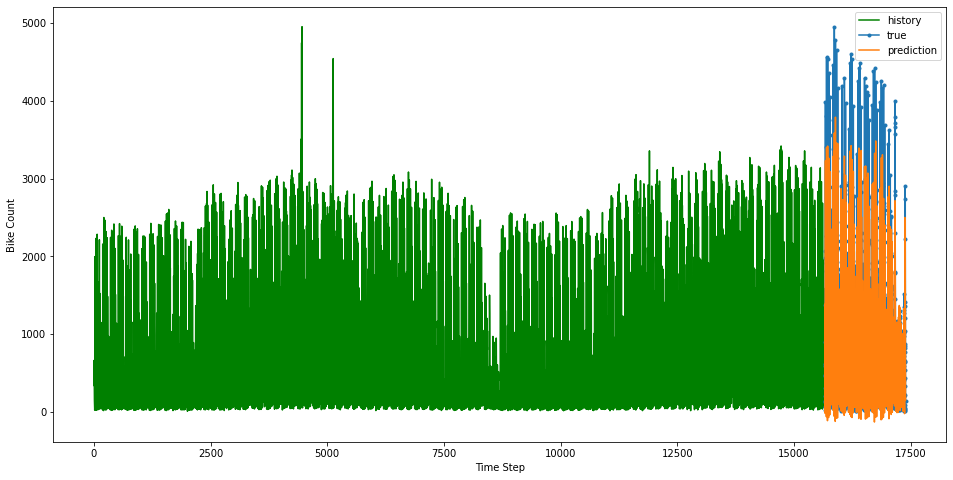

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

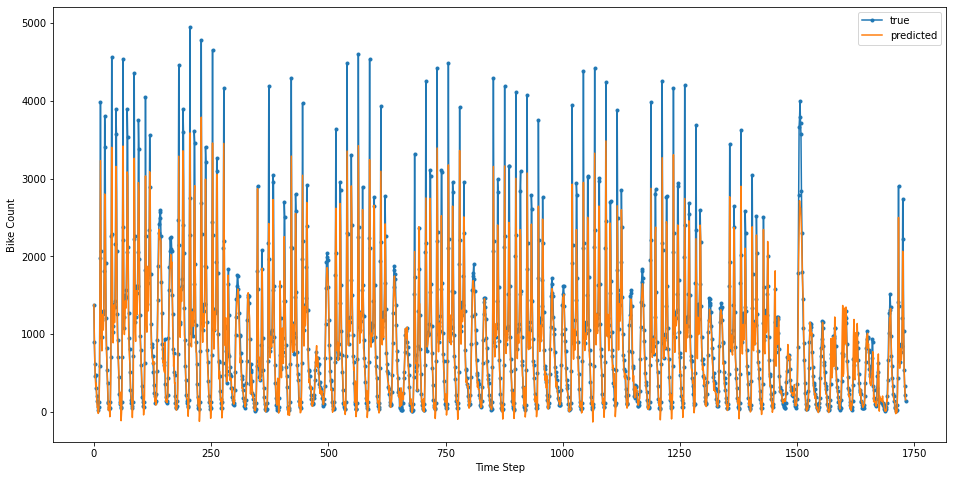

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
y_pred_test_inv

array([[1380.4135 ],
       [ 936.95795],
       [ 610.78827],
       ...,
       [ 354.1295 ],
       [ 238.64658],
       [ 157.14285]], dtype=float32)

In [ ]:
y_test_inv

array([[1376.,  894.,  615., ...,  337.,  224.,  139.]])

In [ ]:
y_pred_test_inv

array([[1380.4135 ],
       [ 936.95795],
       [ 610.78827],
       ...,
       [ 354.1295 ],
       [ 238.64658],
       [ 157.14285]], dtype=float32)

In [ ]:
y_pred_test_inv.flatten()

array([1380.4135 ,  936.95795,  610.78827, ...,  354.1295 ,  238.64658,
        157.14285], dtype=float32)

In [ ]:
y_pred_test_inv.shape

(1732, 1)

In [ ]:
'''
plt.plot(model_0.History["loss"],label="loss")
plt.plot(model_0.History["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")
'''

'\nplt.plot(model_0.History["loss"],label="loss")\nplt.plot(model_0.History["val_loss"],label="val_loss")\nplt.legend(loc="best")\nplt.xlabel("No. Of Epochs")\nplt.ylabel("mse score")\n'

In [ ]:
from sklearn.metrics import mean_squared_error
import math

'''
# make predictions

#y_pred_test = model.predict(X_test)
#y_pred_test = model.predict(X_train)

# invert scaling
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
'''
'''
y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
'''
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 103.15 RMSE
Test Score: 267.44 RMSE


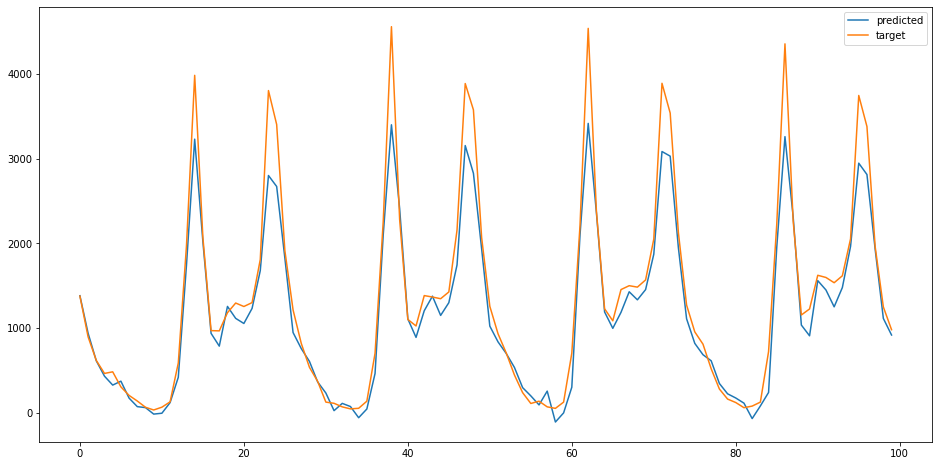

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

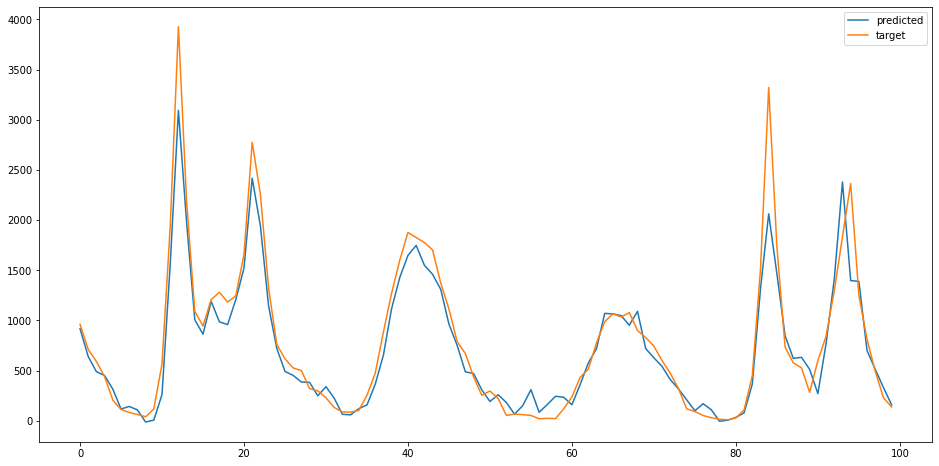

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()